In [1]:
# Getting the version of R used
getRversion()

[1] '4.4.0'

In [2]:
# Load the required libraries
library(lme4)
library(tidyr)
library(haven)
library(dplyr)
library(afex)
library(MuMIn)
library(ggplot2)
library(lcmm)
library(data.table)
library(reshape2)
library(psych)
library(lavaan)


Ikeliamas reikalingas paketas: Matrix




Pridedamas paketas: 'tidyr'


Sie objektai yra uzmaskuoti nuo 'package:Matrix':

    expand, pack, unpack



Pridedamas paketas: 'dplyr'


Sie objektai yra uzmaskuoti nuo 'package:stats':

    filter, lag


Sie objektai yra uzmaskuoti nuo 'package:base':

    intersect, setdiff, setequal, union


************
Welcome to afex. For support visit: http://afex.singmann.science/

- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'S', 'KR', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- Get and set global package options with: afex_options()
- Set sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************


Pridedamas paketas: 'afex'


Sis objektas yra uzmaskuotas nuo 'package:lme4':

    lmer



Pridedamas paketas: 'data.table'


Sie objektai yra uzmaskuoti nuo 'package:dplyr':

    between, first, last



Pridedamas paketas: '

In [3]:
# Function that joins data files together
read_wave_files <- function(wave_number, file_path, keep_vars, new_names, same_vars, files_to_read) {

  wave_data <- NULL

  # Loops throguh every data file
  for (file_name in files_to_read) {
      folder_path_name <- paste0("/sharew", wave_number, "_rel9-0-0_ALL_datasets_spss")
      file_path_name <- paste0("/sharew", wave_number, "_rel9-0-0_", file_name, ".sav")
      full_path <- paste0(file_path, folder_path_name, file_path_name)
      
      # Check if file exists
      if (file.exists(full_path)) {
        # Data file is being red
        file <- read_sav(full_path)

        # Data file is joined with other data files
        if (is.null(wave_data)) {
            wave_data <- file
        } else {
          # Check for variables that are the same every wave
          overlapping_cols <- intersect(names(wave_data), names(file))
          overlapping_cols <- setdiff(overlapping_cols, "mergeid")
          
          wave_data <- wave_data %>%
            inner_join(file %>% select(-all_of(overlapping_cols)), by = "mergeid")
        }
      } else {
        cat("Could not read", file_name, ", ", full_path)
      }
    }

# Check for required variables
  missing_vars <- setdiff(keep_vars, names(wave_data))
  if (length(missing_vars) > 0) {
    cat(wave_number, "wave does not have the variables:", missing_vars, "\n")
  }      

# Filter out unnessecary variables
  wave_data <- wave_data %>%
    select(all_of(intersect(keep_vars, names(wave_data))))


# Add wave number to the variables
  colnames(wave_data) <- sapply(setdiff(keep_vars, missing_vars), function(name) if (name %in% same_vars) name else paste0(name, "_", wave_number))

# Create wave variable
  wave_data <- wave_data %>% 
    mutate(wave = wave_number)  

  return(wave_data)
}


In [4]:
# Path to the folder with data
file_path <- "/Users/rupsy/Desktop/SHARE failai"

# List of files to read
files_to_read <- c("dn", "gv_health", "cv_r", "ac")

# List of variables to filter
keep_vars <- c("mergeid", "country", "age_int",
               "dn014_", "dn042_", "dn044_", 
               "eurod", "casp",
               "ac014_", "ac015_", "ac016_", "ac017_",
               "ac018_", "ac019_", "ac020_", "ac021_",
               "ac022_", "ac023_", "ac024_", "ac025_"
               )

# List of variables that are the same every wave
same_vars <- c("mergeid", "country", "dn042_")

# List with needed waves
waves <- c(1, 2, 4, 5, 6, 7, 8, 9)

In [5]:
# Join together all the wave files
all_waves_list <- lapply(waves, read_wave_files, file_path = file_path, keep_vars = keep_vars, new_names = new_names, same_vars = same_vars, files_to_read = files_to_read)
all_waves <- bind_rows(all_waves_list)


# Sort the datalist
all_waves <- all_waves %>%
  relocate(mergeid, wave) %>%
  arrange(mergeid, wave)

head(all_waves)

1 wave does not have the variables: dn044_ ac014_ ac015_ ac016_ ac017_ ac018_ ac019_ ac020_ ac021_ ac022_ ac023_ ac024_ ac025_ 


mergeid,wave,country,age_int_1,dn014__1,dn042_,eurod_1,casp_1,age_int_2,dn014__2,...,ac016__9,ac017__9,ac018__9,ac019__9,ac020__9,ac021__9,ac022__9,ac023__9,ac024__9,ac025__9
<chr>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,...,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>
AT-000327-01,1,11,51,1,1,0,37,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-000327-01,2,11,NA,NA,1,NA,NA,54,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-000327-02,1,11,48,1,2,1,38,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-000327-02,2,11,NA,NA,2,NA,NA,51,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-000674-01,4,11,NA,NA,2,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-000674-01,5,11,NA,NA,2,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [6]:
# Convert to long format
all_waves_long <- all_waves %>%
  pivot_longer(
    cols = -same_vars,
    names_to = c(".value", "wave"),
    names_pattern = "(.*)_(\\d+)"
  )

# Filter observations where the participant did not participate
all_waves_long <- all_waves_long %>%
  filter(!is.na(age_int))

head(all_waves_long)

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(same_vars)

  # Now:
  data %>% select(all_of(same_vars))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


mergeid,country,dn042_,wave,age_int,dn014_,eurod,casp,dn044_,ac014_,...,ac016_,ac017_,ac018_,ac019_,ac020_,ac021_,ac022_,ac023_,ac024_,ac025_
<chr>,<dbl+lbl>,<dbl+lbl>,<chr>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,...,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>
AT-000327-01,11,1,1,51,1,0,37,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-000327-01,11,1,2,54,NA,9,24,5,3,...,1,4,4,4,1,3,4,4,4,4
AT-000327-02,11,2,1,48,1,1,38,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-000327-02,11,2,2,51,NA,3,30,5,2,...,3,3,2,3,1,2,3,2,3,3
AT-000674-01,11,2,4,59,6,1,44,NA,2,...,4,1,4,2,1,1,1,1,1,1
AT-000674-01,11,2,5,61,NA,0,45,5,3,...,4,1,4,4,1,1,1,1,2,1


In [7]:
# Rename country code to country name
country_names <- c(
  `11` = "Austria",
  `12` = "Germany",
  `13` = "Sweden",
  `14` = "Netherlands",
  `15` = "Spain",
  `16` = "Italy",
  `17` = "France",
  `18` = "Denmark",
  `19` = "Greece",
  `20` = "Switzerland",
  `23` = "Belgium",
  `25` = "Israel",
  `28` = "Czech Republic",
  `29` = "Poland",
  `30` = "Ireland",
  `31` = "Luxembourg",
  `32` = "Hungary",
  `33` = "Portugal",
  `34` = "Slovenia",
  `35` = "Estonia",
  `47` = "Croatia",
  `48` = "Lithuania",
  `51` = "Bulgaria",
  `53` = "Cyprus",
  `55` = "Finland",
  `57` = "Latvia",
  `59` = "Malta",
  `61` = "Romania",
  `63` = "Slovakia"
)

all_waves_long <- all_waves_long %>%
  mutate(country = as.character(country)) %>%
  mutate(country = recode(country, !!!country_names))


In [8]:
# Filter out age <= 50
all_waves_long <- all_waves_long %>%
  filter(age_int >= 50)

head(all_waves_long)


mergeid,country,dn042_,wave,age_int,dn014_,eurod,casp,dn044_,ac014_,...,ac016_,ac017_,ac018_,ac019_,ac020_,ac021_,ac022_,ac023_,ac024_,ac025_
<chr>,<chr>,<dbl+lbl>,<chr>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,...,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>
AT-000327-01,Austria,1,1,51,1,0,37,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-000327-01,Austria,1,2,54,NA,9,24,5,3,...,1,4,4,4,1,3,4,4,4,4
AT-000327-02,Austria,2,2,51,NA,3,30,5,2,...,3,3,2,3,1,2,3,2,3,3
AT-000674-01,Austria,2,4,59,6,1,44,NA,2,...,4,1,4,2,1,1,1,1,1,1
AT-000674-01,Austria,2,5,61,NA,0,45,5,3,...,4,1,4,4,1,1,1,1,2,1
AT-000674-01,Austria,2,6,63,NA,4,44,5,2,...,4,1,4,2,1,1,1,1,1,1


In [9]:
# Answer to marital_status percentage
all_waves_long %>%
  group_by(wave) %>%
  summarise(
    participants = n(),
    percentage_answered = mean(!is.na(dn014_)) * 100)

wave,participants,percentage_answered
<chr>,<int>,<dbl>
1,29151,99.74272
2,36068,45.33659
4,56600,65.49647
5,64861,38.15081
6,67048,22.92835
7,76242,28.85155
8,53217,35.37216
9,68933,26.02092


In [10]:
# Take the marital status from previous waves (as it is not written if it didn't change from the last wave)
all_waves_long <- all_waves_long %>%
  group_by(mergeid) %>%
  arrange(wave) %>%
  mutate(
    dn014_ = if_else(wave > 1 & dn044_ == 5, lag(dn014_, order_by = wave), dn014_)
  ) %>%
  fill(dn014_, .direction = "down") %>% 
  arrange(mergeid, wave) %>%
  ungroup()

head(all_waves_long)

mergeid,country,dn042_,wave,age_int,dn014_,eurod,casp,dn044_,ac014_,...,ac016_,ac017_,ac018_,ac019_,ac020_,ac021_,ac022_,ac023_,ac024_,ac025_
<chr>,<chr>,<dbl+lbl>,<chr>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,...,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>
AT-000327-01,Austria,1,1,51,1,0,37,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-000327-01,Austria,1,2,54,1,9,24,5,3,...,1,4,4,4,1,3,4,4,4,4
AT-000327-02,Austria,2,2,51,NA,3,30,5,2,...,3,3,2,3,1,2,3,2,3,3
AT-000674-01,Austria,2,4,59,NA,1,44,NA,2,...,4,1,4,2,1,1,1,1,1,1
AT-000674-01,Austria,2,5,61,6,0,45,5,3,...,4,1,4,4,1,1,1,1,2,1
AT-000674-01,Austria,2,6,63,6,4,44,5,2,...,4,1,4,2,1,1,1,1,1,1


In [11]:
# Answer to marital_status after transforming
all_waves_long %>%
  group_by(wave) %>%
  summarise(
    participants = n(),
    percentage_answered = mean(!is.na(dn014_)) * 100)

wave,participants,percentage_answered
<chr>,<int>,<dbl>
1,29151,99.74272
2,36068,55.65044
4,56600,34.17845
5,64861,63.03171
6,67048,79.45502
7,76242,73.04242
8,53217,66.63848
9,68933,75.67058


In [12]:
# Create variable "divorced" as the grouping variable and "time" as pre/post divorce

all_waves_long <- all_waves_long %>%
  mutate(wave = as.numeric(wave))

all_waves_divorced_time <- all_waves_long %>%
  group_by(mergeid) %>%
  arrange(wave) %>%
  mutate(
      lag_dn014_ = lag(dn014_, order_by = wave),
      lag_wave = lag(wave, order_by = wave),
      lead_wave = lead(wave, order_by = wave),
      lead_dn014_ = lead(dn014_, order_by = wave),
      wave_diff_lag = wave - lag_wave,
      wave_diff_lead = lead_wave - wave
  ) %>%
  mutate(
    divorced = case_when(
      dn014_ == 5 & lag_dn014_ %in% c(1, 2, 3) & wave_diff_lag == 1 ~ 1,
      dn014_ %in% c(1, 2, 3) & lag_dn014_ %in% c(1, 2, 3) & wave_diff_lag == 1 ~ 0,
      TRUE ~ NA_real_
    ),
  ) %>%
  mutate (
    lead_divorced = lead(divorced, order_by = wave),
    divorced = case_when(
      lead_divorced == 1 ~ 1,
      lead_divorced == 0 ~ 0,
      TRUE ~ divorced
    ) 
  ) %>%
  mutate (
    time = case_when(
      divorced == 1 & dn014_ == 5 ~ 1, 
      divorced == 1 & lead_divorced == 1 ~ 0,
      TRUE ~ NA_real_
    )
  ) %>%
  ungroup() %>%
  select(-lag_dn014_, -lag_wave, -wave_diff_lag, -wave_diff_lead, -lead_wave, -lead_dn014_, - lead_divorced)

head(all_waves_divorced_time)


mergeid,country,dn042_,wave,age_int,dn014_,eurod,casp,dn044_,ac014_,...,ac018_,ac019_,ac020_,ac021_,ac022_,ac023_,ac024_,ac025_,divorced,time
<chr>,<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,...,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>
AT-000327-01,Austria,1,1,51,1,0,37,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,0,NA
AT-001816-01,Austria,2,1,61,1,2,43,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-001816-02,Austria,1,1,56,1,0,43,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,0,NA
AT-002132-01,Austria,2,1,70,6,4,32,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-002355-01,Austria,1,1,71,1,0,47,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AT-002355-02,Austria,2,1,71,1,1,44,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [13]:
# Randomly take only two waves of each participate and get it's time variable
experimental <- all_waves_divorced_time %>%
  filter(divorced == 1)

# Function to randomly pick two adjacent waves
sample_conseq <- function(x, rows) {
  repeat {
    numbers <- 1:(nrow(x) - rows + 1)
    sampled.numbers <- sample(numbers, 1)
    sampled.rows <- seq(sampled.numbers, sampled.numbers + rows - 1)
    
    if (all(diff(x$wave[sampled.rows]) == 1)) {
      result <- x[sampled.rows, ]
      return(result)
    }
  }
}

control <- all_waves_divorced_time %>%
  filter(divorced == 0) %>%
  filter(!mergeid %in% experimental$mergeid) %>%
  group_by(mergeid) %>%
  arrange(wave) %>%
  do(sample_conseq(.,rows = 2)) %>%
  mutate(
    time = row_number() - 1 
  ) %>%
  ungroup()

head(control)

all_waves_divorced_time2 <- bind_rows(experimental, control) %>%
  arrange(mergeid, wave)

head(all_waves_divorced_time2)


mergeid,country,dn042_,wave,age_int,dn014_,eurod,casp,dn044_,ac014_,...,ac018_,ac019_,ac020_,ac021_,ac022_,ac023_,ac024_,ac025_,divorced,time
<chr>,<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,...,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>
AT-000327-01,Austria,1,1,51,1,0,37,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,0,0
AT-000327-01,Austria,1,2,54,1,9,24,5,3,...,4,4,1,3,4,4,4,4,0,1
AT-001492-01,Austria,2,8,68,1,1,38,5,2,...,2,1,1,1,1,2,1,2,0,0
AT-001492-01,Austria,2,9,70,1,1,39,5,3,...,1,2,1,1,2,1,2,2,0,1
AT-001492-02,Austria,1,8,68,1,2,43,5,4,...,4,2,1,1,1,1,1,1,0,0
AT-001492-02,Austria,1,9,70,1,2,46,5,4,...,4,2,1,1,1,1,1,1,0,1


mergeid,country,dn042_,wave,age_int,dn014_,eurod,casp,dn044_,ac014_,...,ac018_,ac019_,ac020_,ac021_,ac022_,ac023_,ac024_,ac025_,divorced,time
<chr>,<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,...,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>
AT-000327-01,Austria,1,1,51,1,0,37,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,0,0
AT-000327-01,Austria,1,2,54,1,9,24,5,3,...,4,4,1,3,4,4,4,4,0,1
AT-001492-01,Austria,2,8,68,1,1,38,5,2,...,2,1,1,1,1,2,1,2,0,0
AT-001492-01,Austria,2,9,70,1,1,39,5,3,...,1,2,1,1,2,1,2,2,0,1
AT-001492-02,Austria,1,8,68,1,2,43,5,4,...,4,2,1,1,1,1,1,1,0,0
AT-001492-02,Austria,1,9,70,1,2,46,5,4,...,4,2,1,1,1,1,1,1,0,1


In [14]:
# Create "waves_compared" variable that shows the waves that are compared

all_waves_divorced_time2 <- all_waves_divorced_time2 %>%
    group_by(mergeid) %>%
    arrange(wave) %>%
    mutate(
        waves_compared = case_when(
            wave == 1 & time == 0 ~ "1 - 2",
            wave == 2 & time == 1 ~ "1 - 2",
            wave == 4 & time == 0 ~ "4 - 5",
            wave == 5 & time == 1 ~ "4 - 5",
            wave == 5 & time == 0 ~ "5 - 6",
            wave == 6 & time == 1 ~ "5 - 6",
            wave == 6 & time == 0 ~ "6 - 7",
            wave == 7 & time == 1 ~ "6 - 7",
            wave == 7 & time == 0 ~ "7 - 8",
            wave == 8 & time == 1 ~ "7 - 8",
            wave == 8 & time == 0 ~ "8 - 9",
            wave == 9 & time == 1 ~ "8 - 9",
            TRUE ~ NA_character_
        )
    ) %>%
    ungroup() %>%
        mutate(waves_compared = 
            factor(waves_compared, levels = unique(waves_compared[!is.na(waves_compared)]))
        )

In [15]:
# Check if there are more than two observations for each participant

all_waves_divorced_time2 %>%
    group_by(mergeid, divorced) %>%
    summarize (
        wave_count = n()
    ) %>%
    ungroup() %>%
    group_by(divorced) %>%
    summarize (
        min_wave_count = min(wave_count),
        max_wave_count = max(wave_count)
    )

# Check if there are same amount of observation.
all_waves_divorced_time2 %>%
    group_by(divorced, time) %>%
    summarize(
        n()
    )

all_waves_divorced_time2 %>%
    group_by(waves_compared, wave, divorced, time) %>%
        summarize(
            count = n()
        )

# Check for unbalanced observations
filter1 <- all_waves_divorced_time2 %>%
    filter(waves_compared == "5 - 6" & wave == 5 & divorced == 0)

filter2 <- all_waves_divorced_time2 %>%
    filter(waves_compared == "5 - 6" & wave == 6 & divorced == 0)

filter3 <- anti_join(filter1, filter2, by = "mergeid")

all_waves_divorced_time2 %>%
    filter(mergeid %in% filter3$mergeid) %>%
    arrange(mergeid, wave)

`summarise()` has grouped output by 'mergeid'. You can override using the
`.groups` argument.


divorced,min_wave_count,max_wave_count
<dbl>,<int>,<int>
0,2,2
1,2,2


`summarise()` has grouped output by 'divorced'. You can override using the
`.groups` argument.


divorced,time,n()
<dbl>,<dbl>,<int>
0,0,47176
0,1,47176
1,0,341
1,1,341


`summarise()` has grouped output by 'waves_compared', 'wave', 'divorced'. You
can override using the `.groups` argument.


waves_compared,wave,divorced,time,count
<fct>,<dbl>,<dbl>,<dbl>,<int>
1 - 2,1,0,0,8620
1 - 2,1,1,0,49
1 - 2,2,0,1,8620
1 - 2,2,1,1,49
4 - 5,4,0,0,3507
4 - 5,4,1,0,24
4 - 5,5,0,1,3507
4 - 5,5,1,1,24
5 - 6,5,0,0,8090


Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


mergeid,country,dn042_,wave,age_int,dn014_,eurod,casp,dn044_,ac014_,...,ac019_,ac020_,ac021_,ac022_,ac023_,ac024_,ac025_,divorced,time,waves_compared
<chr>,<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,...,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>,<fct>


In [16]:
# Filter out participants which have missing waves_compared, casp, country and gender in either observation

all_waves_filtered <- all_waves_divorced_time2 %>%
    group_by(mergeid) %>%
    filter(
        all(
            !is.na(waves_compared) & 
            !is.na(casp) & !casp %in% c(-1, -2) &
            !is.na(country) & !country %in% c(-1, -2) &
            !is.na(dn042_) & !dn042_ %in% c(-1, -2)
        )   
    )

head(all_waves_filtered)

mergeid,country,dn042_,wave,age_int,dn014_,eurod,casp,dn044_,ac014_,...,ac019_,ac020_,ac021_,ac022_,ac023_,ac024_,ac025_,divorced,time,waves_compared
<chr>,<chr>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,...,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>,<fct>
AT-000327-01,Austria,1,1,51,1,0,37,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,0,0,1 - 2
AT-001816-02,Austria,1,1,56,1,0,43,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,0,0,1 - 2
AT-004234-01,Austria,1,1,53,1,2,33,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,0,0,1 - 2
AT-004855-01,Austria,1,1,79,1,9,22,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,0,0,1 - 2
AT-004855-02,Austria,2,1,71,1,2,37,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,0,0,1 - 2
AT-005460-01,Austria,1,1,64,1,2,45,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,0,0,1 - 2


In [17]:
all_waves_filtered %>%
    group_by(waves_compared, wave, divorced, time) %>%
        summarize(
            count = n()
        )

all_waves_filtered %>%
    group_by(waves_compared, divorced) %>%
    summarize(
        participants = n_distinct(mergeid)
    )

all_waves_filtered %>%
    group_by(divorced) %>%
    summarize(
        participants = n_distinct(mergeid)
    )

`summarise()` has grouped output by 'waves_compared', 'wave', 'divorced'. You
can override using the `.groups` argument.


waves_compared,wave,divorced,time,count
<fct>,<dbl>,<dbl>,<dbl>,<int>
1 - 2,1,0,0,5126
1 - 2,1,1,0,31
1 - 2,2,0,1,5126
1 - 2,2,1,1,31
4 - 5,4,0,0,3190
4 - 5,4,1,0,22
4 - 5,5,0,1,3190
4 - 5,5,1,1,22
5 - 6,5,0,0,7199


`summarise()` has grouped output by 'waves_compared'. You can override using
the `.groups` argument.


waves_compared,divorced,participants
<fct>,<dbl>,<int>
1 - 2,0,5126
1 - 2,1,31
4 - 5,0,3190
4 - 5,1,22
5 - 6,0,7199
5 - 6,1,53
6 - 7,0,11787
6 - 7,1,89
7 - 8,0,6699


divorced,participants
<dbl>,<int>
0,40216
1,304


In [18]:
all_waves_final <- all_waves_filtered

# Testing psychometric properties

In [19]:
# Check count by country

all_waves_long %>%
    filter (wave == 8) %>%
    group_by(country) %>%
    summarize(
        participants = n_distinct(mergeid)
    )

country,participants
<chr>,<int>
Austria,1940
Belgium,2242
Bulgaria,898
Croatia,2004
Cyprus,538
Czech Republic,3011
Denmark,2348
Estonia,3364
Finland,1159


In [20]:
print(colnames(all_waves_long))

 [1] "mergeid" "country" "dn042_"  "wave"    "age_int" "dn014_"  "eurod"  
 [8] "casp"    "dn044_"  "ac014_"  "ac015_"  "ac016_"  "ac017_"  "ac018_" 
[15] "ac019_"  "ac020_"  "ac021_"  "ac022_"  "ac023_"  "ac024_"  "ac025_" 


In [21]:
casp_12 <- all_waves_long %>%
    filter(!is.na(casp)) %>%
    select(
        'country', 'casp',
        'ac014_':'ac025_'
        )

rev <- function(item, min_scale, max_scale) {
  return((max_scale + min_scale) - item)
}

colnames(casp_12)[3:14] <- paste0("item_", 1:12)

casp_12 <- casp_12 %>%
    mutate(
        item_4 = rev(item_4, 1, 4),
        item_7 = rev(item_7, 1, 4),
        item_8 = rev(item_8, 1, 4),
        item_9 = rev(item_9, 1, 4),
        item_10 = rev(item_10, 1, 4),
        item_11 = rev(item_11, 1, 4),
        item_12 = rev(item_12, 1, 4)
    )

head(casp_12)


country,casp,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12
<chr>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Austria,37,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
Austria,24,3,1,1,1,4,4,4,2,1,1,1,1
Austria,30,2,2,3,2,2,3,4,3,2,3,2,2
Austria,44,2,4,4,4,4,2,4,4,4,4,4,4
Austria,45,3,3,4,4,4,4,4,4,4,4,3,4
Austria,44,2,4,4,4,4,2,4,4,4,4,4,4


In [22]:
    # Psychometric characteristics of CASP-12

psychometrics_12 <- data.frame(country = character(), 
                            alpha_wellbeing = numeric()
                            )

for(country in unique(casp_12$country)) {
    scale_country <- casp_12 %>%
        filter(country == !!country)

    alpha_wellbeing <- alpha(select(scale_country, item_1:item_12))

    # Construct validity: First-order one factor CFA
    cfa_model <- '
    well_being =~ item_1 + item_2 + item_3 + item_4 + item_5 + item_6 + item_7 + item_8 + item_9 + item_10 + item_11 + item_12
    '

    fit <- cfa(cfa_model, data = scale_country, estimator = "MLR")
    fit_indices <- fitMeasures(fit, c("cfi", "tli", "rmsea"))


    psychometrics_12 <- rbind(psychometrics_12, data.frame(country = country, 
                                                     alpha_wellbeing = round(alpha_wellbeing$total$raw_alpha, 3),
                                                     cfi = round(fit_indices["cfi"], 3),
                                                     tli = round(fit_indices["tli"], 3),
                                                     rmsea = round(fit_indices["rmsea"], 3),
                                                     stringsAsFactors = FALSE))

   
}

psychometrics_12

psychometrics_12 %>%
  summarise(across(where(is.numeric), list(mean = ~mean(. , na.rm = TRUE), sd = ~sd(. , na.rm = TRUE), min = ~min(. , na.rm = TRUE), max = ~max(. , na.rm = TRUE))))
    
    

,country,alpha_wellbeing,cfi,tli,rmsea
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
cfi,Austria,0.811,0.864,0.833,0.094
cfi1,Bulgaria,0.837,0.782,0.734,0.133
cfi2,Belgium,0.784,0.832,0.795,0.091
cfi3,Cyprus,0.821,0.741,0.684,0.142
cfi4,Czech Republic,0.771,0.725,0.664,0.120
cfi5,Switzerland,0.766,0.850,0.817,0.082
cfi6,Germany,0.785,0.844,0.809,0.091
cfi7,Denmark,0.783,0.849,0.815,0.094
cfi8,Estonia,0.801,0.790,0.744,0.111


alpha_wellbeing_mean,alpha_wellbeing_sd,alpha_wellbeing_min,alpha_wellbeing_max,cfi_mean,cfi_sd,cfi_min,cfi_max,tli_mean,tli_sd,tli_min,tli_max,rmsea_mean,rmsea_sd,rmsea_min,rmsea_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7983103,0.03032574,0.745,0.873,0.8037931,0.0431719,0.723,0.864,0.7602414,0.05265769,0.662,0.833,0.110069,0.02012449,0.081,0.143


# Relationship between divorce and well-being: LMM


Atsisiusti dvejetainiai paketai yra
	/var/folders/yb/9jwpq7b106s0yw27rv4f_7gc0000gn/T//RtmpaTDpw1/downloaded_packages


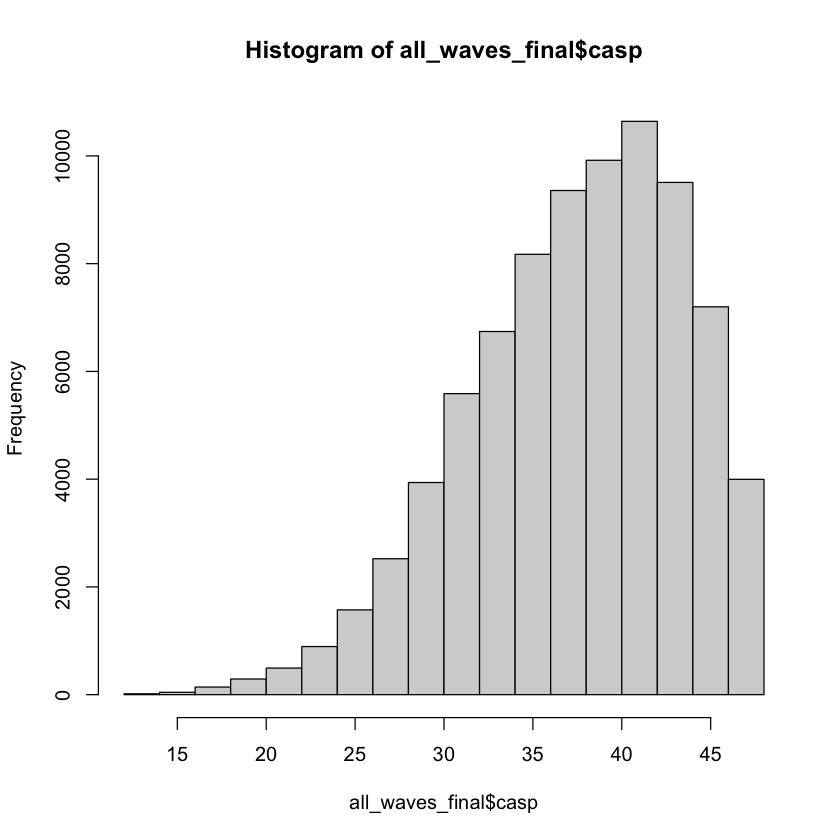

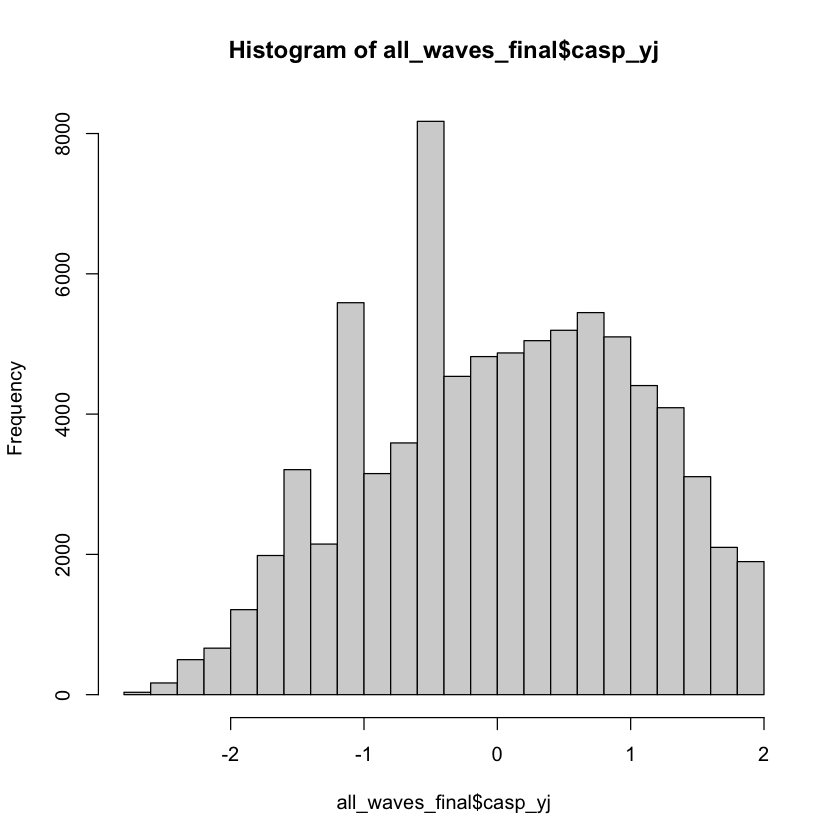

In [25]:
install.packages("bestNormalize")
library(bestNormalize)

hist(all_waves_final$casp)

yj_transformation <- yeojohnson(all_waves_final$casp)
all_waves_final$casp_yj <- yj_transformation$x.t

hist(all_waves_final$casp_yj)


In [28]:
# Create LME and it's summary

model <- lmer(
    casp_yj ~  divorced + time + divorced * time + age_int + dn042_ + 
        (1 | waves_compared) + 
        (1 | country) + 
        (1 + divorced || mergeid),
    data = all_waves_final, 
    control = lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 300000))
)

summary(model)
r.squaredGLMM(model)



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: casp_yj ~ divorced + time + divorced * time + age_int + dn042_ +  
    (1 | waves_compared) + (1 | country) + (1 + divorced || mergeid)
   Data: all_waves_final
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 3e+05))

REML criterion at convergence: 196693.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6276 -0.5293 -0.0079  0.5217  3.4774 

Random effects:
 Groups         Name        Variance Std.Dev.
 mergeid        divorced    0.065509 0.25595 
 mergeid.1      (Intercept) 0.467936 0.68406 
 country        (Intercept) 0.173320 0.41632 
 waves_compared (Intercept) 0.007514 0.08668 
 Residual                   0.342286 0.58505 
Number of obs: 81040, groups:  mergeid, 40520; country, 20; waves_compared, 6

Fixed effects:
                Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    1.210e+00  1.058e-01  2.914e+01  11.434 2.72e-12 ***
div

R2m,R2c
0.02040647,0.6618405


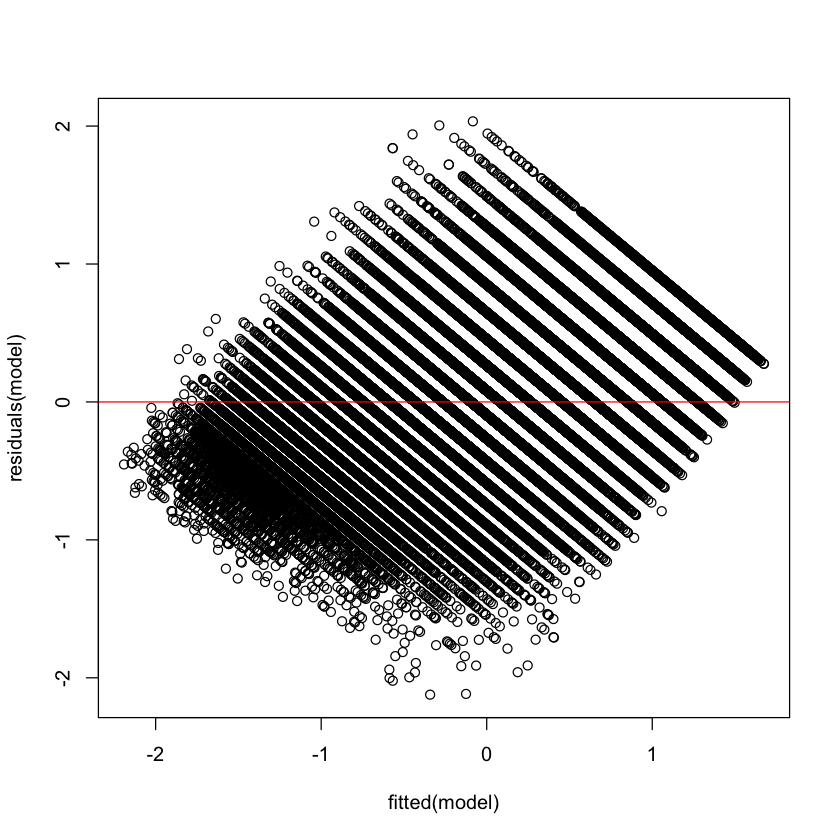

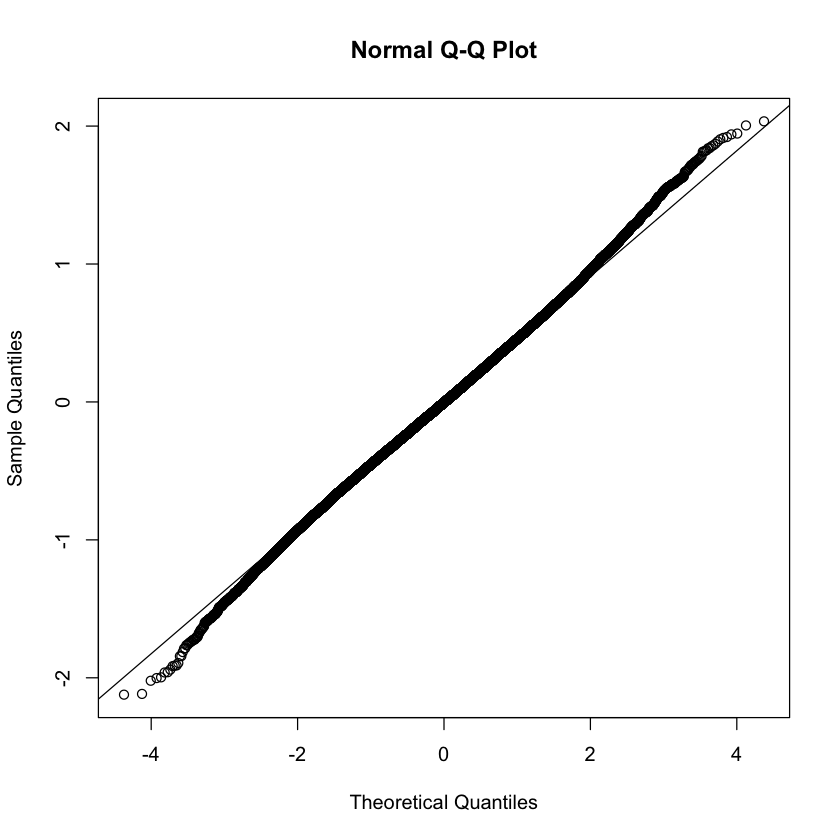

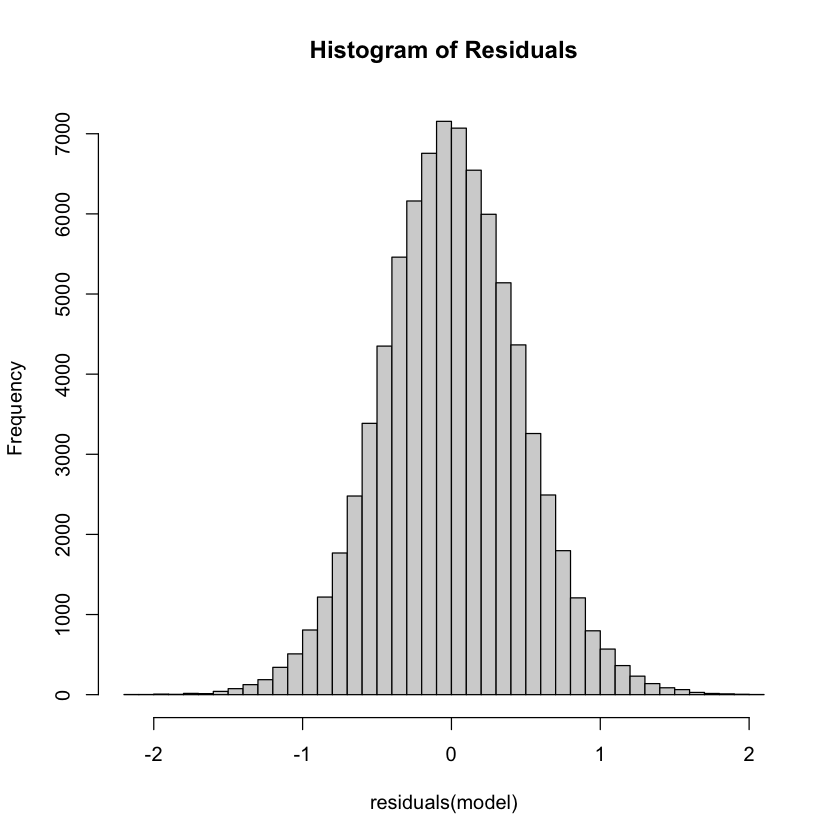

In [29]:
# Function for checking assumptions
check_assumptions <- function(model) {

    # Normality and homoscedacity
    plot(fitted(model), residuals(model))
    abline(h = 0, col = "red")

    # Normality of residuals
    qqnorm(residuals(model))
    qqline(residuals(model))
    hist(residuals(model), breaks = 30, main = "Histogram of Residuals")

}

check_assumptions(model)


In [30]:
# Print demographic variables

all_waves_model <- getData(model)

# Check if the model filter more than it needed to
all_waves_model %>%
    group_by(waves_compared, divorced) %>%
    summarize(
        participants = n_distinct(mergeid)
    )


# Marital status (n)

wave_summary <- all_waves_model %>%
  distinct(mergeid, .keep_all = TRUE) %>%
  group_by(waves_compared) %>%
  summarise(
    divorced_2_yrs = sum(divorced == 1),
    not_divorced = sum(divorced == 0)
  )

wave_summary

wave_summary %>%
  summarise(across(-waves_compared, sum, na.rm = TRUE))

# Marital status (%)

wave_summary <- all_waves_model %>%
  distinct(mergeid, .keep_all = TRUE) %>%
  group_by(waves_compared) %>%
  summarise(
    prop_divorced_2_yrs = round(mean(divorced == 1) * 100, 1),
    prop_not_divorced = round(mean(divorced == 0) *100, 1)
  )

wave_summary

wave_summary %>%
  summarise(across(-waves_compared, mean, na.rm = TRUE))

# Age 
wave_summary <- all_waves_model %>%
  distinct(mergeid, .keep_all = TRUE) %>%
  group_by(waves_compared) %>%
  summarise(
    mean_age = round(mean(age_int), 1),
    std_age = round(sd(age_int), 1),
  )

wave_summary

wave_summary %>%
  summarise(across(-waves_compared, mean, na.rm = TRUE))

# Gender (n)

wave_summary <- all_waves_model %>%
  distinct(mergeid, .keep_all = TRUE) %>%
  group_by(waves_compared) %>%
  summarise(
    male = sum(dn042_ == 1),
    female = sum(dn042_ == 2)
  )

wave_summary

wave_summary %>%
  summarise(across(-waves_compared, sum, na.rm = TRUE))

# Gender (%)

wave_summary <- all_waves_model %>%
  distinct(mergeid, .keep_all = TRUE) %>%
  group_by(waves_compared) %>%
  summarise(
    prop_male = round(mean(dn042_ == 1) * 100, 1),
    prop_female = round(mean(dn042_ == 2) *100, 1)
  )

wave_summary

wave_summary %>%
  summarise(across(-waves_compared, mean, na.rm = TRUE))

`summarise()` has grouped output by 'waves_compared'. You can override using
the `.groups` argument.


waves_compared,divorced,participants
<fct>,<dbl>,<int>
1 - 2,0,5126
1 - 2,1,31
4 - 5,0,3190
4 - 5,1,22
5 - 6,0,7199
5 - 6,1,53
6 - 7,0,11787
6 - 7,1,89
7 - 8,0,6699


waves_compared,divorced_2_yrs,not_divorced
<fct>,<int>,<int>
1 - 2,31,5126
4 - 5,22,3190
5 - 6,53,7199
6 - 7,89,11787
7 - 8,70,6699
8 - 9,39,6215


Warning message:
"There was 1 warning in `summarise()`.
i In argument: `across(-waves_compared, sum, na.rm = TRUE)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))"


divorced_2_yrs,not_divorced
<int>,<int>
304,40216


waves_compared,prop_divorced_2_yrs,prop_not_divorced
<fct>,<dbl>,<dbl>
1 - 2,0.6,99.4
4 - 5,0.7,99.3
5 - 6,0.7,99.3
6 - 7,0.7,99.3
7 - 8,1.0,99.0
8 - 9,0.6,99.4


prop_divorced_2_yrs,prop_not_divorced
<dbl>,<dbl>
0.7166667,99.28333


waves_compared,mean_age,std_age
<fct>,<dbl>,<dbl>
1 - 2,63.2,8.8
4 - 5,67.2,8.2
5 - 6,66.0,8.8
6 - 7,66.4,8.5
7 - 8,66.8,8.3
8 - 9,68.3,7.8


mean_age,std_age
<dbl>,<dbl>
66.31667,8.4


waves_compared,male,female
<fct>,<int>,<int>
1 - 2,2701,2456
4 - 5,1605,1607
5 - 6,3649,3603
6 - 7,5928,5948
7 - 8,3455,3314
8 - 9,3149,3105


male,female
<int>,<int>
20487,20033


waves_compared,prop_male,prop_female
<fct>,<dbl>,<dbl>
1 - 2,52.4,47.6
4 - 5,50.0,50.0
5 - 6,50.3,49.7
6 - 7,49.9,50.1
7 - 8,51.0,49.0
8 - 9,50.4,49.6


prop_male,prop_female
<dbl>,<dbl>
50.66667,49.33333


# Individual differences: GMM

In [31]:
# Convert mergeid to a unique numeric identifier and filter for divorced individuals

all_waves_gmm <- all_waves_final %>%
  group_by(mergeid) %>%
  mutate(mergeid_numeric = cur_group_id()) %>%
  ungroup() %>%
  mutate(
    time = as.factor(time)
  ) %>%
  filter(divorced == 1)

In [32]:
# Create a baseline GMM and create a function to add GMM with more classes
set.seed(2002)

gmm <- hlme(
  fixed = casp ~ time + age_int + dn042_,
  random = ~1 + time,
  subject = "mergeid_numeric",
  ng = 1,
  data = all_waves_gmm,
  idiag = TRUE
)

fitGmm <- function(k) {
    gridsearch(rep = 300, maxiter = 10, minit = gmm,
                    hlme(
                      fixed = casp ~ time  + age_int + dn042_,
                      subject = "mergeid_numeric", 
                      random= ~ 1 + time,
                      ng = k, 
                      data = all_waves_gmm, 
                      mixture = ~time, 
                      nwg = TRUE, 
                      idiag = TRUE))
}

In [33]:
# Create the GMMs
gmms <- list()
gmms[['1']] <- gmm

for (k in 2:5) {
    gmms[[as.character(k)]] <- fitGmm(k)
}

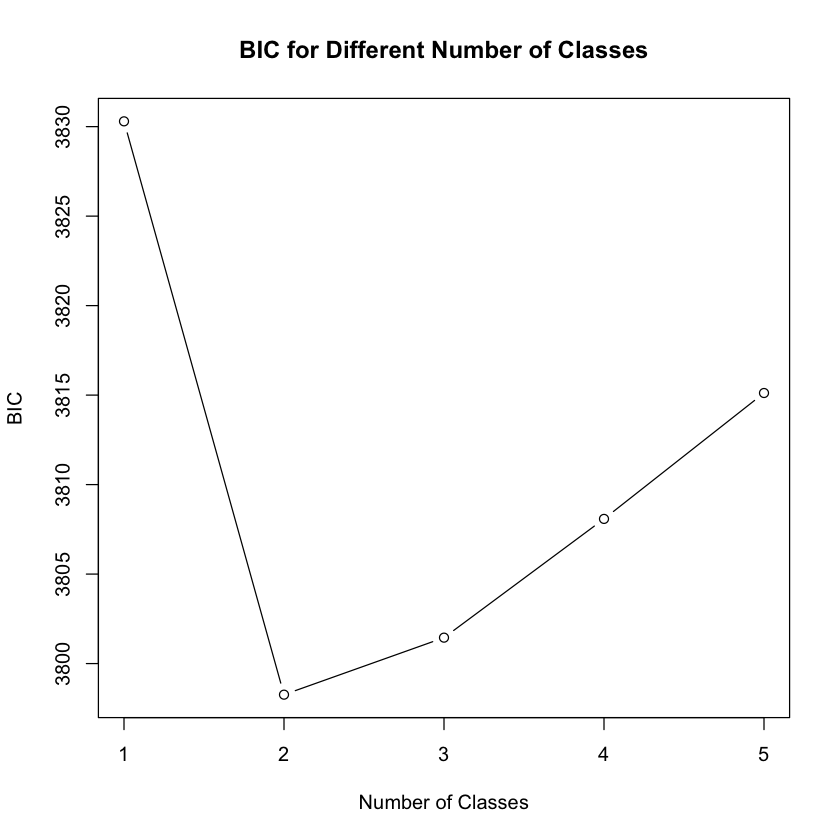

In [34]:
# Plot BIC for each GMM to check how many classes to choose

bic_values <- sapply(gmms, '[[', 'BIC')
par(bg = "white")
plot(as.integer(names(bic_values)), bic_values, type = 'b', xlab = 'Number of Classes', ylab = 'BIC', main = 'BIC for Different Number of Classes')

# Select the best model based on BIC
best_k <- which.min(bic_values)
bestGmm <- gmms[[as.character(best_k)]]

In [35]:
summary(bestGmm)

Heterogenous linear mixed model 
     fitted by maximum likelihood method 
 
hlme(fixed = casp ~ time + age_int + dn042_, mixture = ~time, 
    random = ~1 + time, subject = "mergeid_numeric", ng = k, 
    idiag = TRUE, nwg = TRUE, data = all_waves_gmm)
 
Statistical Model: 
     Dataset: all_waves_gmm 
     Number of subjects: 304 
     Number of observations: 608 
     Number of latent classes: 2 
     Number of parameters: 11  
 
Iteration process: 
     Convergence criteria satisfied 
     Number of iterations:  1 
     Convergence criteria: parameters= 5.3e-11 
                         : likelihood= 6.2e-11 
                         : second derivatives= 1e-11 
 
Goodness-of-fit statistics: 
     maximum log-likelihood: -1867.69  
     AIC: 3757.38  
     BIC: 3798.26  
 
 
Maximum Likelihood Estimates: 
 
Fixed effects in the class-membership model:
(the class of reference is the last class) 

                     coef      Se   Wald p-value
intercept class1  0.03930 0.30612  0.1

In [36]:
# Extract posterior probabilities
post_prob <- bestGmm$pprob

# Assign each individual to the cluster with the highest probability
cluster_assignments <- apply(post_prob[, grep("prob", names(post_prob))], 1, which.max)

# Count the number of individuals in each cluster
cluster_counts <- table(cluster_assignments)

# Calculate percentages
total_individuals <- length(cluster_assignments)
cluster_percentages <- (cluster_counts / total_individuals) * 100

# Combine counts and percentages into a data frame
cluster_summary <- data.frame(
  Cluster = names(cluster_counts),
  Count = as.integer(cluster_counts),
  Percentage = cluster_percentages
)

# Print the cluster summary
print(cluster_summary)

  Cluster Count Percentage.cluster_assignments Percentage.Freq
1       1   175                              1        57.56579
2       2   129                              2        42.43421


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


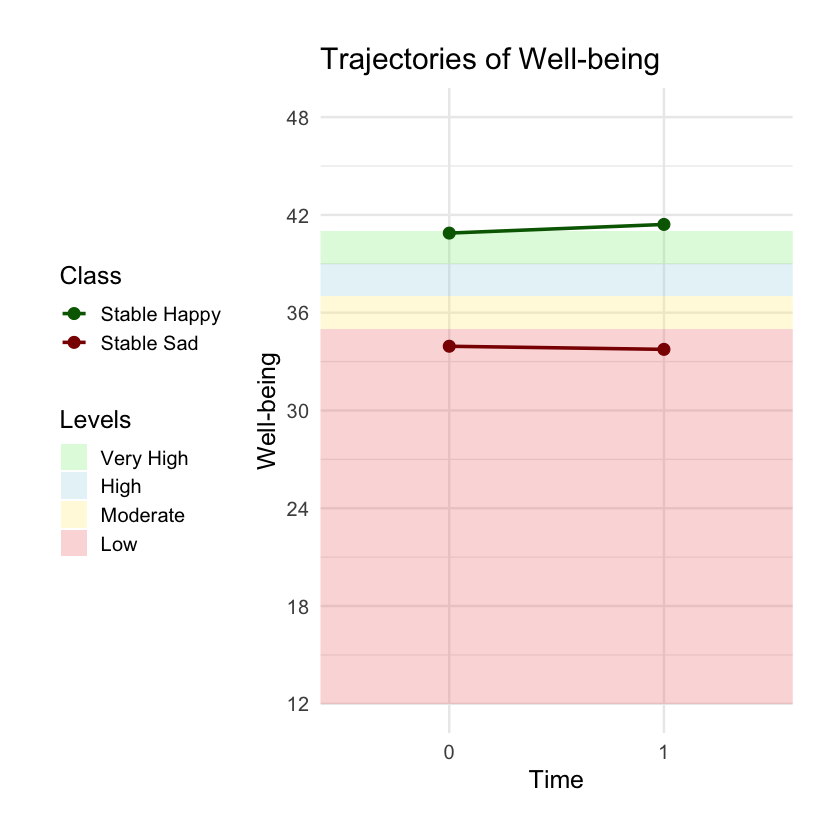

In [37]:
data_pred <- data.frame(
  time = unique(all_waves_gmm$time),
  age_int = mean(all_waves_gmm$age_int, na.rm = TRUE),
  dn042_ = mean(all_waves_gmm$dn042_, na.rm = TRUE)
)

# Predict for each class including covariates
pred <- predictY(bestGmm, newdata = data_pred, var.time = "time")$pred

# Convert prediction to data.table
pred_dt <- as.data.table(pred)
pred_dt[, Time := unique(all_waves_gmm$time)]

# Melt the data for plotting
melted_pred <- melt(pred_dt, id.vars = 'Time', variable.name = 'Class', value.name = 'casp')

# Factorize the Class variable for better readability
melted_pred$Class <- factor(melted_pred$Class, levels = paste0('Ypred_class', 1:best_k), labels = c("Stable Happy", "Stable Sad"))

# Define the well-being levels
well_being_levels <- data.frame(
  y_min = c(39, 37, 35, 12),
  y_max = c(41, 39, 37, 35),
  Levels = factor(c("Very High", "High", "Moderate", "Low"), levels = c("Very High", "High", "Moderate", "Low"))
)

# Plot the predictions
ggplot() +
  geom_rect(data = well_being_levels, aes(xmin = -Inf, xmax = Inf, ymin = y_min, ymax = y_max, fill = Levels), alpha = 0.3) +
  geom_line(data = melted_pred, aes(x = Time, y = casp, color = Class, group = Class), size = 1) +
  geom_point(data = melted_pred, aes(x = Time, y = casp, color = Class), size = 3) +  # Add points to emphasize categories
  labs(
    title = "Trajectories of Well-being",
    x = "Time",
    y = "Well-being",
    color = "Class"
  ) +
  scale_y_continuous(breaks = seq(12, 48, by = 6), limits = c(12, 48)) +
  theme_minimal(base_size = 15) +
  theme(
    legend.position = "left",
    plot.margin = unit(c(1, 1, 1, 1), "cm")  # Add margin around the plot
  ) +
  scale_fill_manual(values = c("Very High" = "lightgreen", "High" = "lightblue", "Moderate" = "lightgoldenrod1", "Low" = "lightcoral")) +
  scale_color_manual(values = c("Stable Happy" = "darkgreen", "Stable Sad" = "darkred"))

# Save the plot with adjusted size
ggsave("well_being_trajectories.png", width = 8, height = 6)